### Updating Dynamics over Time
* use `inertia_of_cubesat` function to instantiate initial inertia matrix
* gather the vertical positions of the terms in `positions`, our nx3 matrix of the pcb positions (impleentation can either pick out all the `z` terms and save in new matrix since these are the only things we care about, or we can just reuse `positions`)
* update `z` values of `positions` after some time step, `dt`.
*      if any positions are updated beyond threshold (`z > threshold`) remove them.
*      recompute inertia matrix on update `positions`
*      store result. I don't think we need to save ALL of the intermediate `positions`, just the most recent one

In [149]:
import numpy as np
import matplotlib.pyplot as plt

##################
# helper functions
##################

# updates positions of PCBsats in CubeSat
# removes PCBsats which were released
def update_positions(positions, z_dot):
    global n
    
    # count records number of released PCBsats
    count = 0
    
    # iterate over each of our 'n' PCBsats
    for row in range(n):
        # increase position by z_dot
        positions[row][2] += z_dot
        
        # increase count when vertical position exceeds THRESHOLD
        if positions[row][2] >= THRESHOLD:
            count += 1       
    
    # decrease number of PCBsats by 'count'
    n -= count
    
# computes translational velocity of leadscrew along z-axis
def v_shaft(w_motor, l_screw):
    return (w_motor * l_screw) / (2 * np.pi)

# computes inertial matrix
# Note: Assumes we can add inertia tensors linearly. CHECK ASSUMPTION
def get_inertial_matrix(MOI_cube, MOI_stac, n, positions):
    J_global = 0
    
    for i in range(n):
        r = positions[i][np.newaxis, :].T
        r_squared = np.dot(positions[i], positions[i])
        
        J = MOI_stac + m_stac * (r_squared * np.identity(3) - r * positions[i])
        J_global += J
    
    return J_global + MOI_cube

In [150]:
##########
# dynamics
##########

def update_dynamics(w_motor, torqueCube, dt):
    global n, angVel, angPositions
    
    # computes/updates new stac velocity
    #v = v_shaft(w_motor, l_screw)  UNCOMMENT IF WE WANT TO USE VARIABLE STAC VELOCITY
    v = 0.254 * 0.01
    
    # z_dot = vertical displacement of pcb's
    z_dot = v * dt
    
    # updates positions of PCBsats in CubeSat
    # removes PCBsats which were released
    update_positions(positions, z_dot)
    
    # compute new inertia matrix with updated positions + number of pcb's
    I.append(get_inertial_matrix(MOI_cube, MOI_stac, n, positions))
    
    # compute/update list of eigenvalues of new inertial matrix
    inertial_matrix_eigenvalues.append(np.linalg.eig(I[-1])[0])
    
    # computes/updates new angular velocity
    angAccel = np.linalg.inv(I[-2]) * torqueCube
    angVel.append(angVel[-1] + angAccel * dt)
    
    # computes/updates new angular positions
    angPositions.append(angPositions[-1] + angVel[-2] * dt)

In [151]:
############
# parameters
############

# n :: number of PCBsats left in CubeSat
# m_stac :: mass of individual PCBsat (KILOGRAMS)
# dt :: time step (SECONDS)
# w_motor :: motor angular velocity (RADIANS / SECOND)
# l_screw :: screw lead (METERS)
# r_screw :: screw radius (METERS)
# v :: translational velocity of screw shaft along z-axis (METERS / SECOND)
# THRESHOLD :: z-axis value at which PCBsat has left CubeSat

# torqueCube :: 3x1 vector torque from coil, reaction wheel, whatever we decide on

# MOI_cube :: 3x3 matrix of moment giving inertia of CubeSat without PCBsats
# MOI_stac :: 3x3 matrix of moment giving inertia of individual PCBsat about it's own axis
# positions :: nx3 matrix giving x y z locations of PCBsats

# I :: list of inertial matrix at each time step
# inertial_matrix_eigenvalues :: list of eigenvalues of inertial matrix at each time step
# v_stac :: list of velocity of PCBsats at each time step
# angVel :: list of angular velocities of PCBsats at each time step
# angPositions :: list of angular positions of CubeSat at each time step

n = 10
m_stac = 100 * (10 ** -3)
dt = 1
#v =  (w_motor * l_screw) / (2 * np.pi)
#torqueCube
THRESHOLD = 22.5

angVel = [np.array([
    [3],
    [3],
    [3]])]  # SET TO OUR INITIAL ANGULAR VELOCITY in rho, phi, theta direction

angPositions = [np.array([
    [1],
    [1],
    [1]])]

MOI_cube = np.array([
    [1308846.485, -10374.412, -13883.462],
    [-10374.412, 1334376.646, -21514.642],
    [-13883.462,-21514.642, 671472.124]]) / 1000000

MOI_stac = np.array([
    [1/12 * (10.1 ** (-4)), 0, 0],
    [0, 1/12 * (10.1 ** (-4)), 0], 
    [0, 0, 1/60000]])

positions = np.array([
    [0, 0, 7.5],
    [0, 0, 9],
    [0, 0, 10.5],
    [0, 0, 12],
    [0, 0, 13.5],
    [0, 0, 15],
    [0, 0, 16.5],
    [0, 0, 18],
    [0, 0, 19.5],
    [0, 0, 21]])

I = [get_inertial_matrix(MOI_cube, MOI_stac, n, positions)]
inertial_matrix_eigenvalues = [np.linalg.eig(I[-1])[0]]

In [176]:
############
# simulation
############

# fills in I, v_stac, angVel lists at each time step in (start, end)

start = 0
end = 60*100

for i in np.arange(start, end+dt, dt):
    update_dynamics(n, np.array([
        [1], [0], [1]
    ]), dt)

### Visualizations
Here we plot the inertial matrix magnitudes in the x, y, and z direction over time. The zig-zagging pattern can be explained by the nature of our PCBsat positions; the sudden drops correspond to the release of a PCBsat, and the following increase results from the stac of PCBsats rising further away from center of mass of the CubeSat.

#### Inertial Matrix Magnitudes over Time

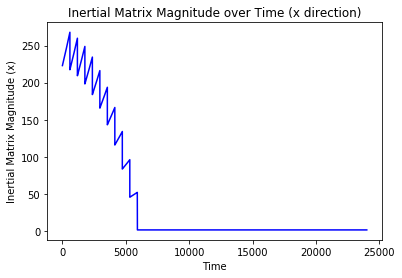

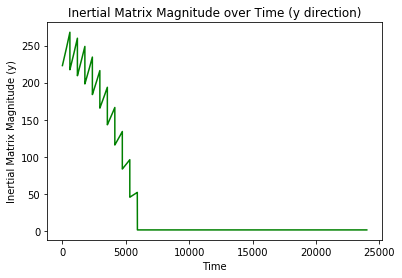

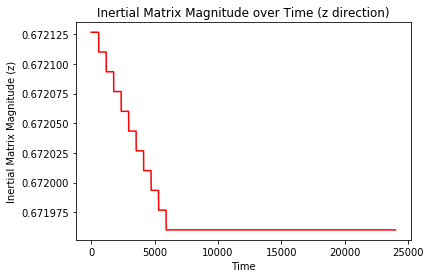

In [179]:
mag_x = []
mag_y = []
mag_z = []

for mat in I:
    x_sq_sum = 0
    y_sq_sum = 0
    z_sq_sum = 0
    
    for row in mat:
        x_sq_sum += row[0]**2
        y_sq_sum += row[1]**2
        z_sq_sum += row[2]**2
    
    mag_x.append(x_sq_sum ** 0.5)
    mag_y.append(y_sq_sum ** 0.5)
    mag_z.append(z_sq_sum ** 0.5)

times = np.arange(start, len(mag_x), dt)

plt.plot(times, mag_x,'b')
plt.xlabel("Time")
plt.ylabel("Inertial Matrix Magnitude (x)")
plt.title("Inertial Matrix Magnitude over Time (x direction)")
plt.figure()
plt.plot(times, mag_y,'g')
plt.xlabel("Time")
plt.ylabel("Inertial Matrix Magnitude (y)")
plt.title("Inertial Matrix Magnitude over Time (y direction)")
plt.figure()
plt.plot(times, mag_z,'r')
plt.xlabel("Time")
plt.ylabel("Inertial Matrix Magnitude (z)")
plt.title("Inertial Matrix Magnitude over Time (z direction)");

#### Angular Positions over Time

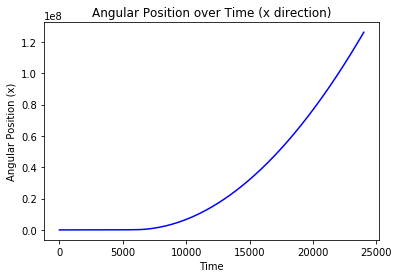

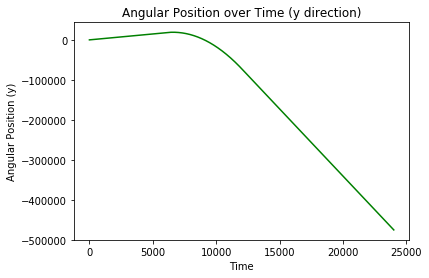

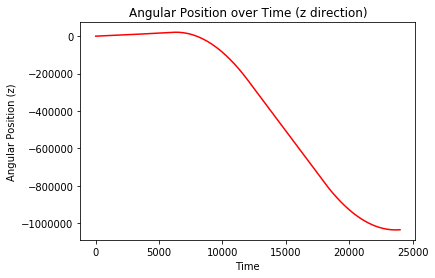

In [177]:
times = np.arange(start, len(angPositions), dt)

angle_x = [vec[0][0] for vec in angPositions]
angle_y = [vec[1][0] for vec in angPositions]
angle_z = [vec[2][0] for vec in angPositions]

times = np.arange(start, len(angPositions), dt)

plt.plot(times, angle_x, 'b')
plt.xlabel("Time")
plt.ylabel("Angular Position (x)")
plt.title("Angular Position over Time (x direction)")
plt.figure()
plt.plot(times, angle_y, 'g')
plt.xlabel("Time")
plt.ylabel("Angular Position (y)")
plt.title("Angular Position over Time (y direction)")
plt.figure()
plt.plot(times, angle_z, 'r')
plt.xlabel("Time")
plt.ylabel("Angular Position (z)")
plt.title("Angular Position over Time (z direction)");